In [3]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles, make_blobs
import pandas as pd
import matplotlib.pyplot as plt
from torchmetrics import Accuracy, F1Score
from helper_functions import plot_decision_boundary, plot_predictions

/tmp/ipykernel_22717/4082650707.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Binary class

In [2]:
x, y = make_circles(n_samples= 1000, noise=0.03, random_state=42)
len(x), len(y)


(1000, 1000)

In [3]:
print(f"First 3 samples of x:\n {x[3:6]}")
print(f"First 3 samples of y:\n {y[3:6]}")

First 3 samples of x:
 [[-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]
 [-0.47964637  0.67643477]]
First 3 samples of y:
 [1 0 1]


In [4]:
circules = pd.DataFrame({"X1": x[:,0], "X2": x[:,1], "label":y})
circules[3:6]

,X1,X2,label
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1


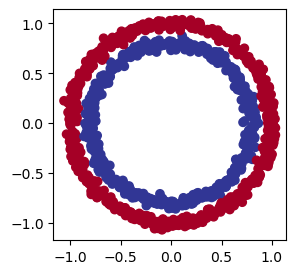

In [5]:
plt.figure(figsize=(3,3))
plt.scatter(circules["X1"], circules["X2"], c=y, cmap=plt.cm.RdYlBu)
#plt.scatter(x= x[:,0], y=x[:,1], c=y, cmap=plt.cm.RdYlBu)

In [6]:
x.shape, y.shape

((1000, 2), (1000,))

In [7]:
type(x)

numpy.ndarray

In [8]:
# change to tensor
x = torch.from_numpy(x).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)
type(x)

torch.Tensor

In [9]:
# split data
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=42)
len(x_train), len(x_test)

(800, 200)

In [10]:
x_train.dim(), y_train.dim()

(2, 1)

In [11]:
# build a model
dev = "cuda" if torch.cuda.is_available() else "cpu"

class CirclesModel_0(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        # Iniciar los layers con el N° de x's y terminar con el output de y
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # take in 2 features and upscale to 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previus layer and outputs a single features (dim = y)

    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> layer1 -> layer2 -> y
    
model_0 = CirclesModel_0().to(dev)
model_0

CirclesModel_0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

## Replicate the model using nn.Sequential

In [12]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5), 
    nn.Linear(in_features=5, out_features=1)
).to(dev)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
model_0.state_dict() # 5 tensores por lado por el out_features

OrderedDict([('0.weight',
              tensor([[ 0.3698, -0.3940],
                      [-0.1603, -0.5266],
                      [ 0.0024,  0.5051],
                      [-0.6742,  0.3876],
                      [ 0.6899,  0.0709]], device='cuda:0')),
             ('0.bias',
              tensor([-0.4762,  0.6248,  0.0877,  0.5292,  0.2350], device='cuda:0')),
             ('1.weight',
              tensor([[-0.1743,  0.3538,  0.1263,  0.3523, -0.4176]], device='cuda:0')),
             ('1.bias', tensor([-0.0605], device='cuda:0'))])

In [14]:
with torch.inference_mode():
    untrained_pred = model_0(x_test.to(dev)) # make predictions
print(f"Length of prediction: {len(untrained_pred)} | Shape: {untrained_pred.shape}")
print(f"Length of test: {len(x_test)} | Shape test: {x_test.shape}")
print(f"\First 5 predictions: {untrained_pred[:5]}")
print(f"\nFirst 5 labels: \n{y_test[:5]}")

Length of prediction: 200 | Shape: torch.Size([200, 1])
Length of test: 200 | Shape test: torch.Size([200, 2])
\First 5 predictions: tensor([[0.6218],
        [0.3840],
        [0.7805],
        [0.5787],
        [0.0433]], device='cuda:0')

First 5 labels: 
tensor([1., 0., 1., 0., 1.])


In [15]:
# Setup the loss function
loss_fn = nn.BCEWithLogitsLoss() # Combine a Sigmoid layer and the BCELoss in one single class.
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [16]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return correct/len(y_pred) * 100
    

In [34]:
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(x_test.to(dev))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')

In [35]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [36]:
y_pred_prob = torch.sigmoid(y_logits)
y_pred_prob

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')

In [37]:
y_preds = torch.round(y_pred_prob) # find the pred labels
y_pred_label = torch.round( torch.sigmoid(model_0(x_test.to(dev))[:5]))
print(torch.eq(y_preds.squeeze(), y_pred_label.squeeze())) # check for equality

tensor([True, True, True, True, True], device='cuda:0')


In [38]:
# build a train and test
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 100

x_train, y_train,  = x_train.to(dev), y_train.to(dev)
x_test , y_test = x_test.to(dev),  y_test.to(dev)

for epoch in range(epochs):

    model_0.train()
    y_logits = model_0(x_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred label
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred= y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # testing
    model_0.eval() 
    with torch.inference_mode():
        test_logits = model_0(x_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        #calcule test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    if epoch % 20 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.3f} | Test loss: {test_loss:.3f} | Test acc: {test_acc:.3f}%")       

Epoch: 0 | Loss: 0.698 | Test loss: 0.694 | Test acc: 51.875%
Epoch: 20 | Loss: 0.695 | Test loss: 0.693 | Test acc: 51.625%
Epoch: 40 | Loss: 0.694 | Test loss: 0.692 | Test acc: 50.875%
Epoch: 60 | Loss: 0.694 | Test loss: 0.692 | Test acc: 50.000%
Epoch: 80 | Loss: 0.693 | Test loss: 0.693 | Test acc: 49.875%


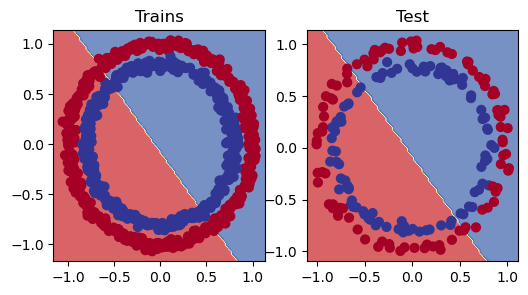

In [24]:
# plot decision
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title("Trains")
plot_decision_boundary(model= model_0, X= x_train, y= y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model=model_0, X=x_test, y=y_test)

## Improving a model used more layers

In [2]:
class CirclesModel_1(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        return self.layer_3(self.layer_2(self.layer_1(x)))  # Es lo mismo de arriba

model_1 = CirclesModel_1().to(dev)
model_1

NameError: name 'dev' is not defined

In [26]:
# Setup the loss function
loss_fn = nn.BCEWithLogitsLoss() # Combine a Sigmoid layer and the BCELoss in one single class.
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.001)

In [28]:
# build a train and test
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 1000

x_train, y_train,  = x_train.to(dev), y_train.to(dev)
x_test , y_test = x_test.to(dev),  y_test.to(dev)

for epoch in range(epochs):

    model_1.train()
    y_logits = model_1(x_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred label
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred= y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(x_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred= test_pred)

    if epoch % 200 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.3f} | Test loss: {test_loss:.3f} | Test acc: {test_acc:.3f}%")       

Epoch: 0 | Loss: 0.694 | Test loss: 0.693 | Test acc: 50.500%
Epoch: 200 | Loss: 0.694 | Test loss: 0.693 | Test acc: 51.000%
Epoch: 400 | Loss: 0.694 | Test loss: 0.693 | Test acc: 50.500%
Epoch: 600 | Loss: 0.694 | Test loss: 0.693 | Test acc: 50.000%
Epoch: 800 | Loss: 0.694 | Test loss: 0.693 | Test acc: 50.000%


# Build No-Linear

In [26]:
# create, change to tensor and split data
x, y = make_circles(n_samples= 1000, noise=0.03, random_state=42)

x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=42)


In [27]:
class CirclesModel_2(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # non-linear
    
    def forward(self,x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_2 = CirclesModel_2().to(dev)
model_2

CirclesModel_2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [28]:
# Setup the loss function
loss_fn = nn.BCEWithLogitsLoss() # Combine a Sigmoid layer and the BCELoss in one single class.
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)

In [29]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

x_train, y_train,  = x_train.to(dev), y_train.to(dev)
x_test , y_test = x_test.to(dev),  y_test.to(dev)

epochs = 2000

for epoch in range(epochs):

    model_2.train()
    y_logits = model_2(x_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    acc = accuracy_fn(y_true=y_train, y_pred= y_pred)

    model_2.eval() 
    with torch.inference_mode():
        test_logits = model_2(x_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        #calcule test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    if epoch % 200 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.3f} | Test loss: {test_loss:.3f} | Test acc: {test_acc:.3f}%")       

RuntimeError: result type Float can't be cast to the desired output type Long

In [25]:
loss, test_loss, test_acc

NameError: name 'loss' is not defined

In [41]:
# Make predictions
model_2.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_2(x_test))).squeeze()
y_preds[:10], y_test[:10] # want preds in same format as truth labels


(tensor([1., 1., 1., 0., 1., 1., 0., 0., 1., 1.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

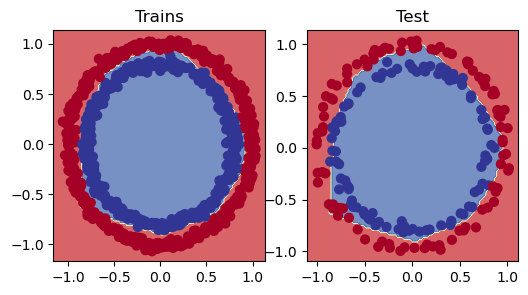

In [48]:
# plot decision
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title("Trains")
plot_decision_boundary(model= model_2, X= x_train, y= y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model=model_2, X=x_test, y=y_test)

# Multiclass Clasification

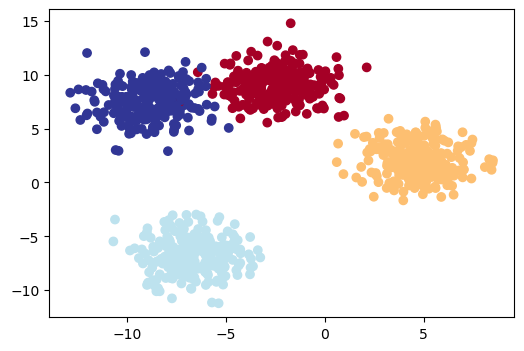

In [5]:
# data 
x, y = make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.5, random_state=42)
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.long)

# split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

# plot
plt.figure(figsize=(6,4))
plt.scatter(x[:,0], x[:,1], c=y, cmap=plt.cm.RdYlBu)

In [6]:
# def accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return correct/len(y_pred) * 100

# device
dev = "cuda" if torch.cuda.is_available() else "cpu"
dev

'cuda'

In [7]:
""" build mode
        input_features = N° of input features to the model
        out_features = N° of outputs features (number of outputs classes)
        hidden_units = N° of hidden units between layers, defaul 8

"""
class BlobModel(nn.Module):
    def __init__(self, input_features, out_features, hidden_units = 8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=out_features)
        )
    def forward(self, x):
        return  torch.softmax(self.linear_layer_stack(x), dim=1) # softmax for more the 2 clasification, same that logits
    
model_3 = BlobModel(input_features= 2, out_features=4, hidden_units=8).to(dev)
model_3

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [8]:
# loss
loss_fn = nn.CrossEntropyLoss()

# opimizer
optimizer = torch.optim.SGD(params= model_3.parameters(), lr= 0.1)

In [9]:
model_3.eval()
with torch.inference_mode():
    y_preds = model_3(x_test.to(dev))

# prob de cada class a la que puede pertenecer
y_preds[:5]   

tensor([[0.2297, 0.2029, 0.2000, 0.3675],
        [0.2229, 0.2773, 0.2165, 0.2832],
        [0.1545, 0.3110, 0.2494, 0.2851],
        [0.2256, 0.2366, 0.2108, 0.3270],
        [0.2327, 0.2889, 0.1894, 0.2890]], device='cuda:0')

In [10]:
a = torch.argmax(y_preds, dim=1)    # select the more high value prob
a[:5]

tensor([3, 3, 1, 3, 3], device='cuda:0')

In [11]:
y_test[:5]

tensor([1, 3, 2, 1, 0])

In [12]:
# creating a loop for train and test
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

x_train, x_test = x_train.to(dev), x_test.to(dev)
y_train, y_test = y_train.to(dev), y_test.to(dev)
for epoch in range(epochs):

    model_3.train()
    y_logits_class = model_3(x_train)
    #y_pred = torch.softmax(y_logits_class, dim=1).argmax(dim=1)
    y_pred = y_logits_class.argmax(dim=1)
    loss = loss_fn(y_logits_class, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(x_test)
        test_pred = test_logits.argmax(dim=1)
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

    if epoch % 20 == 0:
        print(f"epoch: {epoch} | loss: {loss:.4f} | Acc:{acc:.2f} test loss: {test_loss:.4f} | test acc: {test_acc:.4f}%")


epoch: 0 | loss: 1.3932 | Acc:24.50 test loss: 1.3776 | test acc: 46.5000%
epoch: 20 | loss: 1.1500 | Acc:58.88 test loss: 1.1496 | test acc: 60.0000%
epoch: 40 | loss: 1.0699 | Acc:68.12 test loss: 1.0834 | test acc: 74.5000%
epoch: 60 | loss: 0.9913 | Acc:75.62 test loss: 1.0073 | test acc: 71.5000%
epoch: 80 | loss: 0.9096 | Acc:96.25 test loss: 0.9203 | test acc: 95.0000%


In [13]:
# Making and evaluating predictions 
model_3.eval()
with torch.inference_mode():
    y_logits_pred = model_3(x_test)
torch.argmax(y_logits_pred[:5], dim=1)

tensor([1, 3, 2, 1, 0], device='cuda:0')

In [14]:
y_test[:5]

tensor([1, 3, 2, 1, 0], device='cuda:0')

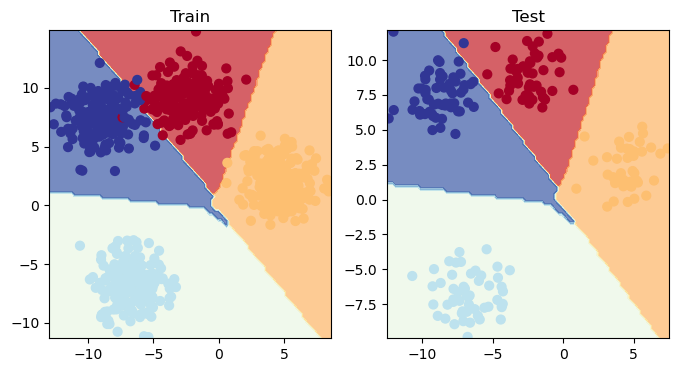

In [15]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model=model_3, X=x_train, y=y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model=model_3, X=x_test, y=y_test)

In [16]:
# A few more classification metrics mode
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(dev)

# Calculate accuracy
torchmetrics_accuracy(y_logits_pred, y_test)

tensor(0.9950, device='cuda:0')

In [17]:
torchmetrics_f1score = F1Score(task='multiclass', num_classes=4).to(dev)

# Calculate accuracy
torchmetrics_f1score(y_logits_pred, y_test)

tensor(0.9950, device='cuda:0')

In [18]:

# 29